# k-Nearest Neighbors

k-nearest neighbors is relatively simple in its predictions because it only requires:
- some notion of distance between points, accounting for each dimmension
- an assumption taht points that are close to one another in input space are close output space

#### Advantages:
- because you only need to look at the k-closest points, instead of measuring from the whole dataset. Similarly, there are no parameters to learn: the training data (in k-nearest subsets) is the model

#### Disadvantages:
- no notion or insight into drivers or causality: e.g. predicting a voters selection based on neighbors tells you nothing about *why* that neighborhood votes that way



In [1]:
# Awful hack to import past chapter modules
import sys, copy, os, csv, random, requests, tqdm
sys.path.insert(0, "../")

from typing import List, TypeVar, NamedTuple, Dict, Tuple, Set
from collections import Counter, defaultdict
from linalg import Vector, distance
from matplotlib import pyplot as plt

from machine_learning import split_data, f1_score

In [2]:
Y = TypeVar('Y')

# knn in the 0 feature case is just a raw majority vote
def raw_plural_vote(ys: List[Y]) -> Y:
    """
    Return the most frequently occurring y (ties broken arbitrarily)
    """
    counts = Counter(ys)
    winner, count = counts.most_common(1)[0]
    return winner

assert raw_plural_vote(['a', 'b', 'b', 'c']) == 'b'

In [3]:
def plural_vote(ys: List[Y]) -> Y:
    """
    Return the most frequently occurring y (ties broken by iteratively diregarding neighbors)
    """
    vote_counts = Counter(ys)
    winner, max_count = vote_counts.most_common(1)[0]
    num_winners = sum([1 for c in vote_counts.values() if c == max_count])
    if num_winners == 1:
        return winner
    else:
        # we can filter the list before shortening: we only want to consider labels that have max_count, 
        # as only their removal can bring us to the base case
        new_ys = [y for i, y in enumerate(ys) if vote_counts[y] == max_count and i < len(ys) - 1]
        return plural_vote(new_ys)
        
assert plural_vote(['a', 'b', 'b', 'c', 'a', 'd']) == 'b'

In [4]:
class LabeledPoint(NamedTuple):
    point: Vector  # our features
    label: Y  # our target (note, this doesn't quite work for true generics)


def knn_classify(k: int, data: List[LabeledPoint], new_point: Vector) -> Y:
    """
    Using k-nearest neighbors, attempt to classify the new_point using Labeled data points in data
    """
    # sort from nearest to farthest from new_point
    sorted_by_distance = sorted(data, key=lambda lp: distance(lp.point, new_point))
    # find nearest k
    k_nearest_labels = [lp.label for lp in sorted_by_distance[0:k]]
    # let them vote
    return plural_vote(k_nearest_labels)

In [5]:
# load iris data if needed
IRIS_FNAME = 'iris.dat'
if not os.path.isfile(IRIS_FNAME):
    print('Downloading and saving iris data')
    response = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data')
    with open(IRIS_FNAME, 'w') as f:
        f.write(response.text)

In [6]:
def parse_iris_row(row: List[str]) -> LabeledPoint:
    """
    parse iris row into something usable by our classifier
    """
    label = row[-1].split("-")[-1]  # Iris-virginica -> virginica
    measurements = [float(val) for val in row[:-1]]
    return LabeledPoint(measurements, label)

with open(IRIS_FNAME, 'r') as f:
    reader = csv.reader(f)
    iris_data: List[LabeledPoint] = [parse_iris_row(r) for r in reader if len(r) > 0]

In [7]:
points_by_species: Dict[str, List[Vector]] = defaultdict(list)
for iris in iris_data:
    points_by_species[iris.label].append(iris.point)

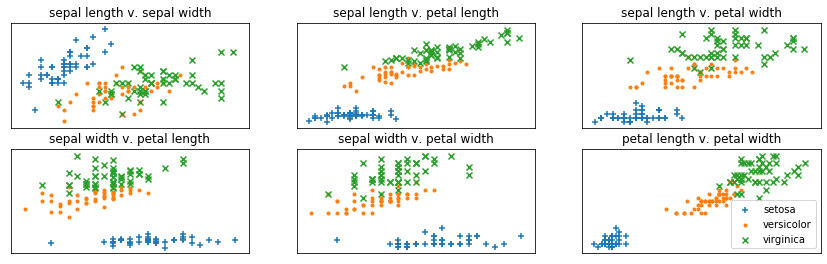

In [8]:
# plot features pair-wise against labels
metrics = ['sepal length', 'sepal width', 'petal length', 'petal width']
# dont plot a metric vs itself, do lesser vs. greater
pairs = [(i, j) for i in range(len(metrics)) for j in range(len(metrics)) if i < j] 
marks = ['+', '.', 'x']  # we have 3 iris types, so 3 markers
fig, ax = plt.subplots(2, 3)
for row in range(2):
    for col in range(3):
        i, j = pairs[3 * row + col]
        plot = ax[row][col]
        plot.set_title('{0} v. {1}'.format(metrics[i], metrics[j]))
        # clear tick marks, we dont need these
        plot.set_xticks([])
        plot.set_yticks([])
        for mark, (species, points) in zip(marks, points_by_species.items()):
            xs1 = [point[i] for point in points]
            xs2 = [point[j] for point in points]
            ax[row][col].scatter(xs1, xs2, marker=mark, label=species)
ax[-1][-1].legend(loc='lower right', prop={'size': 10})
plt.subplots_adjust(bottom=0.1, right=2.0, top=0.9)
plt.show()

Looking at only the charts, we can observe several pairs that provide separation of classes: particularly petal length v. width, and sepal length v. petal length

### Using KNN to predict iris sub-class

First, we'll split data into a training and test set. 

##### Is this even needed for KNN?

Sort of, the test set is what we'll use to evaluate KNN in this context. A validation set might also be used to determine the best hyper-parameter `K` for this data

In [9]:
# initialize a random seed so our results repeat
random.seed(12)
iris_train, iris_test = split_data(iris_data, .70)

In [10]:
# a dictionary of (predicted, actual) labels, which can be turned into F1 scores, etc.
confusion_matrix: Dict[Tuple[str, str], int] = defaultdict(int)
correct_total: int = 0

# iterate over each test-set iris, and insert its outcome into the confusion matrix
for iris in iris_test:
    predicted = knn_classify(k=5, data=iris_train, new_point=iris.point)
    actual = iris.label
    if actual == predicted:
        correct_total += 1
    confusion_matrix[(predicted, actual)] += 1

pct_correct = float(correct_total) / len(iris_test)
print('Accuracy:', pct_correct)

Accuracy: 0.9777777777777777


##### Interpretting the confusion martrices

In [11]:
# lets assume our entire dataset contains all actual classes
def get_f1_scores(confusion_matrix: Dict[Tuple[str, str], int], data: List[LabeledPoint]) -> Dict[str, float]:
    all_labels: Set[str] = set([iris.label for iris in iris_data])
    f1_scores: Dict[str, float] = defaultdict(float)
    for label in all_labels:
        other_labels: Set[str] = all_labels - {label}
        # lets get true/false positives/negatives for each label
        tp = confusion_matrix[(label, label)]
        fp = sum([confusion_matrix[(label, other)] for other in other_labels])
        tn = sum([confusion_matrix[(o1, o2)] for o1 in other_labels for o2 in other_labels])
        fn = sum([confusion_matrix[(other, label)] for other in other_labels])
        f1_scores[label] = f1_score(tp, fp, fn, tn)
    return f1_scores

In [12]:
f1_scores: Dict[str, float] = get_f1_scores(confusion_matrix, iris_data)
for label in f1_scores:
    print('F1 Score ({0}): {1}'.format(label, f1_scores[label]))
assert f1_scores['setosa'] == 1.0
assert f1_scores['versicolor'] > .965
assert f1_scores['virginica'] > .965

F1 Score (setosa): 1.0
F1 Score (versicolor): 0.967741935483871
F1 Score (virginica): 0.9696969696969697


### Choosing the best k

Suppose we didn't know 5 was a good value for k. We can create a validation set and plot the various accuracies (or F1 scores) for different values of k.

In [13]:
# so as to not be stateful across cells, using a new variable for this other split
new_iris_train_and_valid, new_iris_test = split_data(iris_data, .8)
new_iris_train, new_iris_valid =  split_data(new_iris_train_and_valid, .8)
# 150 total -> 30 test, 96 train, 24 valid
assert len(new_iris_train) == 96 and len(new_iris_valid) == 24 and len(new_iris_test) == 30

In [14]:
f1_scores_by_k: Dict[int, Dict[str, float]] = defaultdict(dict)
accuracies_by_k: Dict[int, float] = defaultdict(float)

# lets guess that k is between 1 and 15
for k in range(1, 16):
    confusion_matrix: Dict[Tuple[str, str], int] = defaultdict(int)
    correct_total: int = 0

    # iterate over each test-set iris, and insert its outcome into the confusion matrix
    for iris in new_iris_valid:
        predicted = knn_classify(k=k, data=new_iris_train, new_point=iris.point)
        actual = iris.label
        if actual == predicted:
            correct_total += 1
        confusion_matrix[(predicted, actual)] += 1
    pct_correct = float(correct_total) / len(new_iris_valid)
    accuracies_by_k[k] = pct_correct
    f1_scores_by_k[k] = get_f1_scores(confusion_matrix, iris_data)

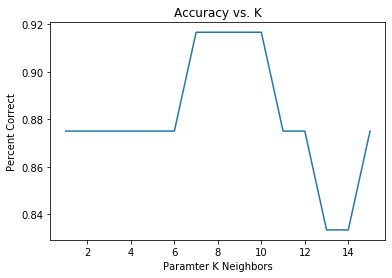

In [15]:
# Now lets plot the data (accuracy)
xs, ys = zip(*accuracies_by_k.items())  # python unzip magic
plt.plot(xs, ys)
plt.title('Accuracy vs. K')
plt.xlabel('Paramter K Neighbors')
plt.ylabel('Percent Correct')
plt.show()

Neat trick from matplotlib:

```
**Plotting labelled data**

    There's a convenient way for plotting objects with labelled data (i.e.
    data that can be accessed by index ``obj['y']``). Instead of giving
    the data in *x* and *y*, you can provide the object in the *data*
    parameter and just give the labels for *x* and *y*::

    >>> plot('xlabel', 'ylabel', data=obj)
```

**^ that didn't end up being useful in this context**

defaultdict(<class 'float'>, {'setosa': 1.0, 'versicolor': 0.823529411764706, 'virginica': 0.7692307692307692})
15 setosa
15 versicolor
15 virginica


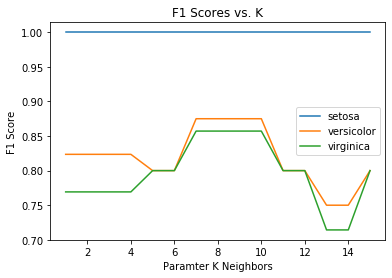

In [16]:
# Now lets plot the data (f1 score)
plt.title('F1 Scores vs. K')
xs = range(1, 16)
print(f1_scores_by_k[1])
for label in all_labels:
    print(k, label)
    plt.plot(xs, [f1_scores_by_k[k][label] for k in xs], label=label)
plt.xlabel('Paramter K Neighbors')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

Our valdation set might be too small to conclude from given in the plain train/test split we get better-than-shown-here values at k=5, but from this analysis our best guess would be some k between 7-10. Lets try with the full split again, but k=8

In [17]:
# a dictionary of (predicted, actual) labels, which can be turned into F1 scores, etc.
confusion_matrix: Dict[Tuple[str, str], int] = defaultdict(int)
correct_total: int = 0

# iterate over each test-set iris, and insert its outcome into the confusion matrix
for iris in iris_test:
    predicted = knn_classify(k=8, data=iris_train, new_point=iris.point)
    actual = iris.label
    if actual == predicted:
        correct_total += 1
    confusion_matrix[(predicted, actual)] += 1

pct_correct = float(correct_total) / len(iris_test)
print('Accuracy:', pct_correct)

f1_scores: Dict[str, float] = get_f1_scores(confusion_matrix, iris_data)
for label in f1_scores:
    print('F1 Score ({0}): {1}'.format(label, f1_scores[label]))
assert f1_scores['setosa'] == 1.0
assert f1_scores['versicolor'] > .965
assert f1_scores['virginica'] > .965

Accuracy: 0.9777777777777777
F1 Score (setosa): 1.0
F1 Score (versicolor): 0.967741935483871
F1 Score (virginica): 0.9696969696969697


Expanding to 10, we get a perfect score (though doing so defeats the purpose of having a 'test' set)

In [18]:
# a dictionary of (predicted, actual) labels, which can be turned into F1 scores, etc.
confusion_matrix: Dict[Tuple[str, str], int] = defaultdict(int)
correct_total: int = 0

# iterate over each test-set iris, and insert its outcome into the confusion matrix
for iris in iris_test:
    predicted = knn_classify(k=10, data=iris_train, new_point=iris.point)
    actual = iris.label
    if actual == predicted:
        correct_total += 1
    confusion_matrix[(predicted, actual)] += 1

pct_correct = float(correct_total) / len(iris_test)
print('Accuracy:', pct_correct)

f1_scores: Dict[str, float] = get_f1_scores(confusion_matrix, iris_data)
for label in f1_scores:
    print('F1 Score ({0}): {1}'.format(label, f1_scores[label]))
assert f1_scores['setosa'] == 1.0
assert f1_scores['versicolor'] == 1.0
assert f1_scores['virginica'] == 1.0

Accuracy: 1.0
F1 Score (setosa): 1.0
F1 Score (versicolor): 1.0
F1 Score (virginica): 1.0


## Curse of Dimmensionality

KNN is a great algorithm in low-dimmensional spaces, but breaks down in higher dimmensions due to the 'curse of dimmensionality'. In short, higher-dimmensional spaces are increasingly vast, and so neighbors are less-and-less reliable as distances increase greatly. KNN works best when your training data densely samples the full space, which is essentially impossible at higher and higher dimmensions.

A demo:

In [19]:
def random_point(dim: int) -> Vector:
    """
    random-point in R^dim (each dimmensions val in [0, 1)])
    """
    return [random.random() for _ in range(dim)]

def random_distances(dim: int, num_pairs: int) -> List[float]:
    """
    For demo purposes, computing distances between num_pairs pairs of random points, each w/ dim=dim
    """
    return [distance(random_point(dim), random_point(dim)) for _ in range(num_pairs)]

In [20]:
# plotting random distances for N=constant pairs over increasing dimmensions
dims = range(1, 101)
avg_distances: List[float] = []
min_distances: List[float] = []

random.seed(0)

for dim in tqdm.tqdm(dims, desc='Curse of Dimmensionality'):
    distances = random_distances(dim, 10000)    
    avg_distances.append(sum(distances) / 10000.)
    min_distances.append(min(distances))

Curse of Dimmensionality: 100%|██████████| 100/100 [00:20<00:00,  5.00it/s]


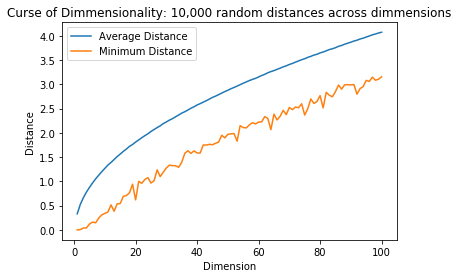

In [21]:
# actually plot (separate cell to avoid repeated execution of above)
plt.plot(dims, avg_distances, label='Average Distance')
plt.plot(dims, min_distances, label='Minimum Distance')
plt.title('Curse of Dimmensionality: 10,000 random distances across dimmensions')
plt.xlabel('Dimension')
plt.ylabel('Distance')
plt.legend()
plt.show()

More problematic is the ratio between minimum and average distance: in low dimmensional spaces, data points tend to be much closer than average: your nearest neighbors are closer to you than your average neighbor and thus can provide real information in the distance metrics if all your features are meaningful. However in high dimmensional spaces, the minimum gets closer to the average (ratio -> 1), and thus your nearest neighbors become indistiguishable from the rest.

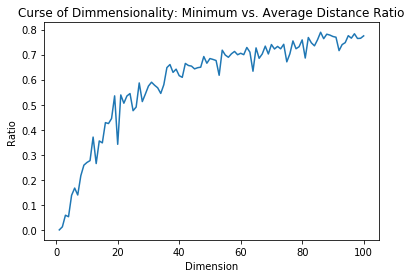

In [22]:
min_avg_ratio = [min_dist / avg_dist for min_dist, avg_dist in zip(min_distances, avg_distances)]
plt.plot(dims, min_avg_ratio, label='Ratio')
plt.title('Curse of Dimmensionality: Minimum vs. Average Distance Ratio')
plt.xlabel('Dimension')
plt.ylabel('Ratio')
plt.show()

Another way of thinking about it: the higher the number of dimmensions, the greater the number of samples that are needed to densely represent the space.

I believe it is exponential in terms of `d`, but won't attempt to fully prove. Basic insight [here](https://en.wikipedia.org/wiki/Curse_of_dimensionality)

In short, each dimmension exponentiall increases the total space in `[0, 10)^d` (`d=1 -> 10, d=2 -> 100`). For a space where each dimmension is bound `[0, N)`, there is `N^d` total space (extrapolating to infinite spaces, one can still see the ~exponential increase in space/sparsity)